In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.decomposition import PCA
from scipy.stats import chi2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import scipy.stats as stats
from scipy.stats import f
from scipy.stats import norm
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

EDA

In [56]:
# Input file path
file_path = 'Converted_CSVs/1_simulation_dataset.csv'
# File paths
file_path_normal = 'Converted_CSVs/1_simulation_dataset.csv'
file_path_faulty = 'Converted_CSVs/1_simulation_dataset_faulty.csv'
# Read the CSV file
df = pd.read_csv(file_path)
# Read the CSV files
df_normal = pd.read_csv(file_path_normal)
df_faulty = pd.read_csv(file_path_faulty)
# Extract the sample column and features from both dataframes
sample_column = df_normal.iloc[:, 2]  # 3rd column (sample)
feature_columns = df_normal.columns[3:]  # Next 52 columns (features)
fault_number_column = 'faultNumber'  # Column with fault numbers




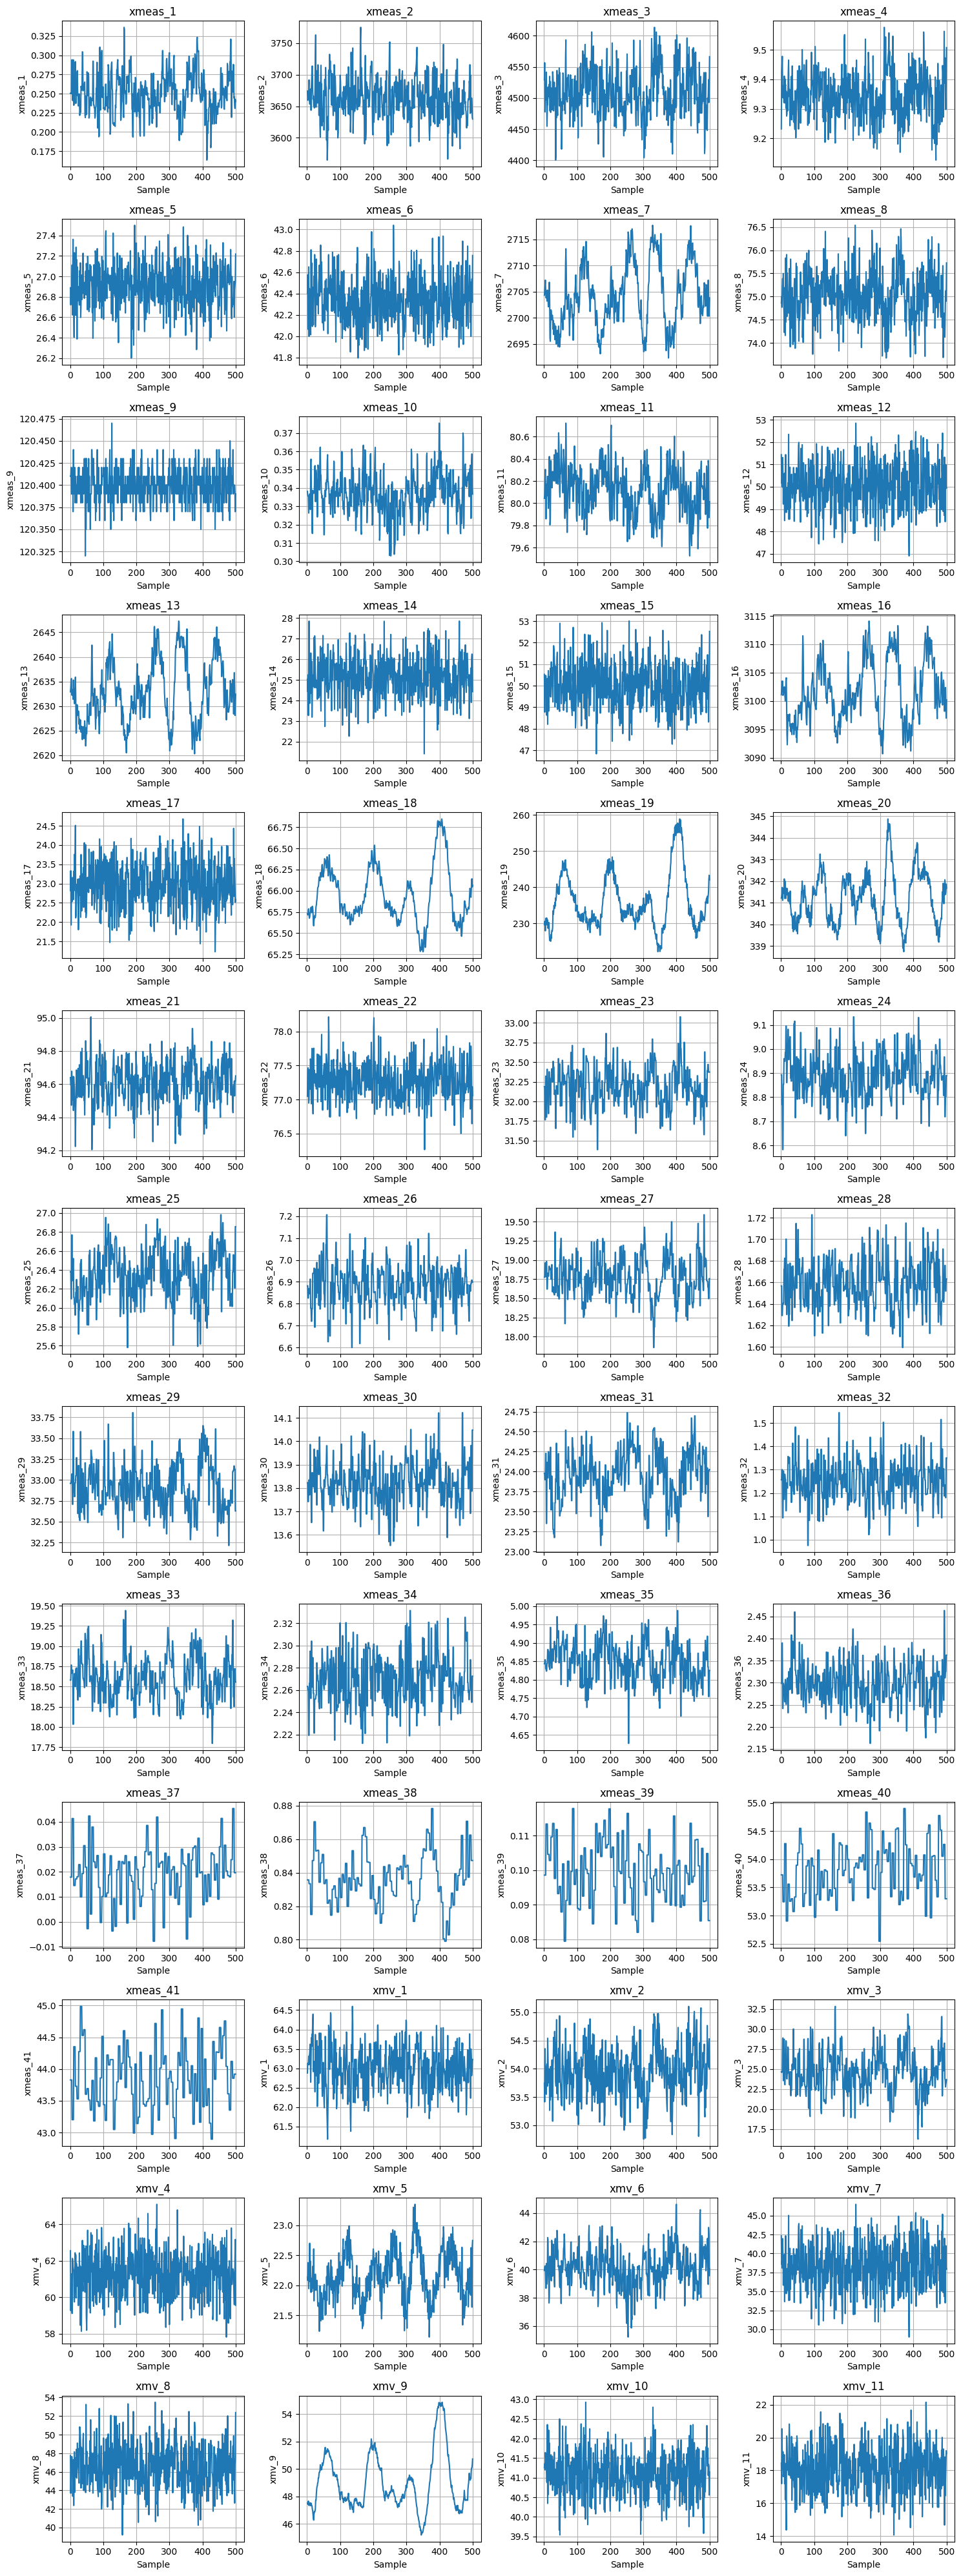

In [3]:
# Extract the sample column and features (assuming sample is in the 3rd column and features are next 52 columns)
sample_column = df.iloc[:, 2]  # 3rd column
feature_columns = df.columns[3:]  # Next 52 columns (from column 4 onwards)

# Set up the plot grid (4 columns and 13 rows)
fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(15, 40))
axes = axes.flatten()  # Flatten the axes to easily access them in a loop

# Loop through each feature and plot against sample
for i, feature in enumerate(feature_columns):
    axes[i].plot(sample_column, df[feature], label=feature)
    axes[i].set_title(feature)
    axes[i].set_xlabel('Sample')
    axes[i].set_ylabel(feature)
    axes[i].grid(True)

# Adjust layout and display all plots
plt.tight_layout()
plt.show()

In [4]:
# Create a folder to save the figures
output_folder = 'fault_plots'
os.makedirs(output_folder, exist_ok=True)

# Loop through each fault number (1 to 20) and plot the features in a separate grid
for fault_num in range(1, 21):  # Fault numbers 1 to 20
    # Create a new figure for each fault with a 4x13 grid
    fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(15, 40))  # 4 columns, 13 rows
    axes = axes.flatten()  # Flatten the axes to easily access them in a loop
    
    # Filter the faulty dataset for the current fault number
    df_faulty_fault = df_faulty[df_faulty[fault_number_column] == fault_num]

    # Filter the data where faultNumber = 0 (no faults) from the normal dataset
    df_normal_no_fault = df_normal[df_normal[fault_number_column] == 0]

    plot_index = 0
    for feature in feature_columns:
        # Plot the feature from the normal dataset (no fault) against the sample column
        axes[plot_index].plot(sample_column, df_normal_no_fault[feature], label=f'No Fault', linestyle='-', color='b')
        
        # Plot the feature from the faulty dataset for the current fault number
        axes[plot_index].plot(sample_column, df_faulty_fault[feature], label=f'Fault {fault_num}', linestyle='--', color='r')
        
        axes[plot_index].set_title(f'Feature: {feature}')
        axes[plot_index].set_xlabel('Sample')
        axes[plot_index].set_ylabel(f'{feature}')
        axes[plot_index].grid(True)
        axes[plot_index].legend()

        # Increment the plot index
        plot_index += 1
    
    # Adjust layout for better visualization
    plt.tight_layout()
    plt.suptitle(f'Fault {fault_num} - Feature Comparisons', fontsize=16)

    # Save the figure to the folder with a filename based on the fault number
    plt.savefig(f'{output_folder}/fault_{fault_num}_feature_comparisons.png')
    plt.close()  # Close the figure to avoid memory issues

print(f'Figures have been saved to the "{output_folder}" folder.')


Figures have been saved to the "fault_plots" folder.


In [5]:
# Create a folder to save the heatmaps
output_folder = 'fault_heatmaps'
os.makedirs(output_folder, exist_ok=True)

# Loop through each fault number (including 0 for no fault) and create a heatmap
for fault_num in range(0, 21):  # Fault numbers 0 to 20
    if fault_num == 0:
        # Use the dataset with no faults (faultNumber = 0)
        df = df_normal[df_normal[fault_number_column] == 0]
    else:
        # Use the dataset with the current fault number
        df = df_faulty[df_faulty[fault_number_column] == fault_num]

    # Extract only the feature columns for correlation calculation
    df_features = df[feature_columns]

    # Calculate the correlation matrix
    corr_matrix = df_features.corr()

    # Create a heatmap
    plt.figure(figsize=(15, 12))
    sns.heatmap(corr_matrix, cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
    
    # Set title
    plt.title(f'Feature Correlation Heatmap - Fault {fault_num}', fontsize=16)
    
    # Save the heatmap as an image
    plt.savefig(f'{output_folder}/fault_{fault_num}_feature_correlation_heatmap.png')
    plt.close()  # Close the figure to avoid memory issues

print(f'Feature correlation heatmaps have been saved to the "{output_folder}" folder.')

Feature correlation heatmaps have been saved to the "fault_heatmaps" folder.


In [6]:
output_folder = 'fault_distribution_grids'
os.makedirs(output_folder, exist_ok=True)

# Loop through each fault number (including 0 for no fault) and create distribution grid plots
for fault_num in range(0, 21):  # Fault numbers 0 to 20
    # Use the dataset with no faults (faultNumber = 0) for fault 0
    if fault_num == 0:
        df = df_normal[df_normal[fault_number_column] == 0]
    else:
        # Use the dataset with the current fault number
        df = df_faulty[df_faulty[fault_number_column] == fault_num]

    # Create a new figure for each fault with a 4x13 grid
    plt.figure(figsize=(15, 40))
    
    # Plot the distribution for each feature
    for i, feature in enumerate(feature_columns):
        plt.subplot(13, 4, i + 1)  # Create a 4x13 grid of subplots

        # Get the min and max values of the feature in both fault 0 and fault n datasets
        min_value = min(df_normal[df_normal[fault_number_column] == 0][feature].min(), 
                        df[df[fault_number_column] == fault_num][feature].min())
        max_value = max(df_normal[df_normal[fault_number_column] == 0][feature].max(), 
                        df[df[fault_number_column] == fault_num][feature].max())
        
        # Create bins based on the feature's min and max values
        bins = np.linspace(min_value, max_value, 20)  # Adjust bin size as needed

        # Plot the distribution for the no-fault data (fault 0)
        sns.histplot(df_normal[df_normal[fault_number_column] == 0][feature], bins=bins, kde=True, color='blue', label='No Fault', stat='density')
        
        # Plot the distribution for the current fault number (fault n)
        sns.histplot(df[df[fault_number_column] == fault_num][feature], bins=bins, kde=True, color='red', label=f'Fault {fault_num}', stat='density')

        # Add title and labels for each subplot
        plt.title(f'{feature}', fontsize=8)
        plt.xlabel('Value', fontsize=6)
        plt.ylabel('Density', fontsize=6)
        plt.legend(fontsize=6)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure for the current fault
    plt.savefig(f'{output_folder}/fault_{fault_num}_distribution_grid.png')
    plt.close()  # Close the figure to avoid memory issues

print(f'Distribution grids have been saved to the "{output_folder}" folder.')

Distribution grids have been saved to the "fault_distribution_grids" folder.


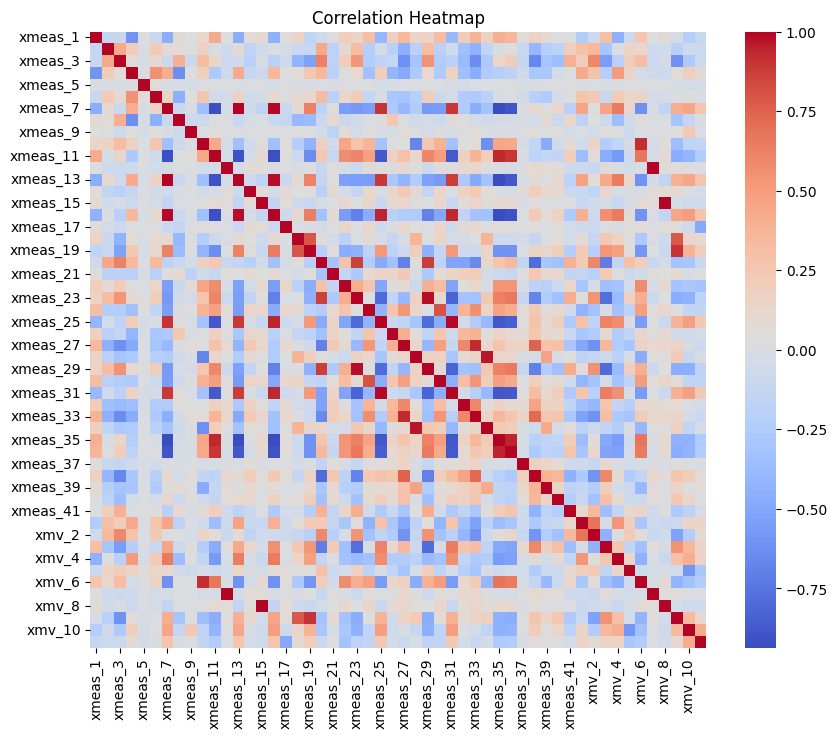

In [7]:
data = pd.read_csv('Converted_CSVs/simulation_dataset_first_5.csv')
data_reduced = data.iloc[:, 3:]
corr_matrix = data_reduced.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with annotations and color map
sns.heatmap(corr_matrix, cmap='coolwarm', cbar=True, square=True)

# Set title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

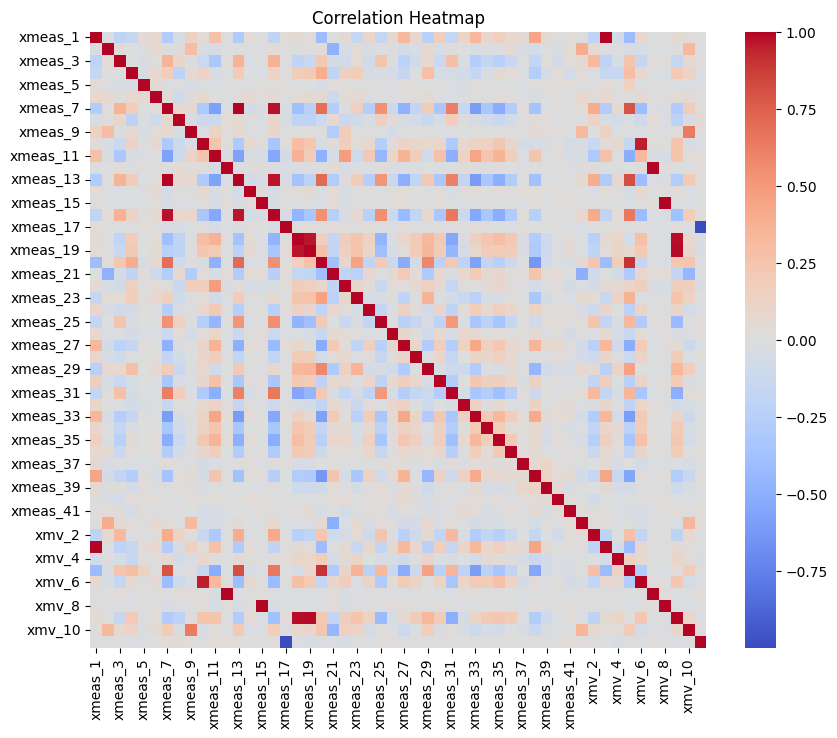

In [8]:
data = pd.read_csv('Converted_CSVs/simulation_dataset_first_5_faultfree.csv')
data_reduced = data.iloc[:, 3:]
corr_matrix = data_reduced.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with annotations and color map
sns.heatmap(corr_matrix, cmap='coolwarm', cbar=True, square=True)

# Set title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

Fault Detection

1.) Data Preparation

In [2]:
# File paths
file_path_fault_free = 'Converted_CSVs/simulation_dataset_first_5_faultfree.csv'
file_path_faulty = 'Converted_CSVs/simulation_dataset_first_5.csv'

# Read the datasets
df_fault_free = pd.read_csv(file_path_fault_free)
df_faulty = pd.read_csv(file_path_faulty)



# Identify columns to exclude from normalization (these are identifiers or non-measurement columns)
non_numeric_columns = ['faultNumber', 'simulationRun', 'sample']

# Get the measurement columns (to normalize)
feature_columns = [col for col in df_fault_free.columns if col not in non_numeric_columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the fault-free dataset
scaler.fit(df_fault_free[feature_columns])

# Transform both datasets
df_fault_free[feature_columns] = scaler.transform(df_fault_free[feature_columns])
df_faulty[feature_columns] = scaler.transform(df_faulty[feature_columns])

2.) Data reduction and reconstruction

In [3]:
# Perform PCA for Fault Detection
# Fit PCA on the fault-free data (we use only the measurement columns)
pca = PCA(n_components=32)  # Retain 95% of variance
faultfree_pca = pca.fit_transform(df_fault_free[feature_columns])

# Transform the faulty data using the same PCA
faulty_pca = pca.transform(df_faulty[feature_columns])

# Reconstruct the fault-free and faulty data from PCA components
faultfree_reconstructed = pca.inverse_transform(faultfree_pca)
faulty_reconstructed = pca.inverse_transform(faulty_pca)

In [ ]:
file_path_fault_free_testing = 'Converted_CSVs/simulation_dataset_first_5_faultfree_testing.csv'
file_path_faulty_testing = 'Converted_CSVs/simulation_dataset_first_5_testing.csv'

# Read the datasets
df_fault_free_testing = pd.read_csv(file_path_fault_free_testing)
df_faulty_testing = pd.read_csv(file_path_faulty_testing)

# Transform both datasets
df_fault_free_testing[feature_columns] = scaler.transform(df_fault_free_testing[feature_columns])
df_faulty_testing[feature_columns] = scaler.transform(df_faulty_testing[feature_columns])

faultfree_pca_testing = pca.transform(df_fault_free_testing[feature_columns])

# Transform the faulty data using the same PCA
faulty_pca_testing = pca.transform(df_faulty_testing[feature_columns])

In [188]:
# Set the number of components for ICA
ica = FastICA(n_components=32, tol = 1e-2, max_iter = 50000, random_state=42)  # Adjust n_components as needed

# Fit ICA on the fault-free data (unsupervised)
faultfree_ica = ica.fit_transform(df_fault_free[feature_columns])

# Transform the faulty data using the same ICA model
faulty_ica = ica.transform(df_faulty[feature_columns])

# Reconstruct the fault-free and faulty data from ICA components
faultfree_reconstructed = ica.inverse_transform(faultfree_ica)
faulty_reconstructed = ica.inverse_transform(faulty_ica)


In [ ]:
##### from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Fit FDA on the fault-free data (requires class labels)
fda = LDA(n_components=1)  # Choose the number of components (e.g., 1 for binary classification)
faultfree_labels = [0] * len(df_fault_free)  # Assign class labels (0 for fault-free)
faulty_labels = [1] * len(df_faulty)        # Assign class labels (1 for faulty)

# Combine fault-free and faulty data for FDA training
combined_data = pd.concat([df_fault_free[feature_columns], df_faulty[feature_columns]])
combined_labels = faultfree_labels + faulty_labels

# Fit the FDA model
fda.fit(combined_data, combined_labels)

# Transform the data using the FDA
faultfree_fda = fda.transform(df_fault_free[feature_columns])
faulty_fda = fda.transform(df_faulty[feature_columns])

# Reconstruct the fault-free and faulty data (note: FDA does not directly provide reconstruction)
# In most cases, FDA is used for classification, so reconstruction might not be meaningful.
# If you want to proceed, you can map the transformed features back to the original space:
faultfree_reconstructed = fda.inverse_transform(faultfree_fda)
faulty_reconstructed = fda.inverse_transform(faulty_fda)


In [175]:
# Fit KernelPCA on the fault-free data (using RBF kernel here)
pca = KernelPCA(kernel='rbf', n_components=32, gamma=0.1,fit_inverse_transform=True)  # Adjust gamma based on your data
faultfree_kpca = pca.fit_transform(df_fault_free[feature_columns])

# Transform the faulty data using the same KPCA
faulty_kpca = pca.transform(df_faulty[feature_columns])

# Reconstruct the fault-free and faulty data from the KPCA components
faultfree_reconstructed = pca.inverse_transform(faultfree_kpca)
faulty_reconstructed = pca.inverse_transform(faulty_kpca)


In [127]:
import pandas as pd
from sklearn.decomposition import PCA

# Function to create augmented data matrix for DPCA
def create_augmented_matrix(data, lags, label_columns):
    augmented_data = []
    labels = []
    feature_data = data.iloc[:, len(label_columns):]  # Select all feature columns after the label columns
    for i in range(lags, len(data)):
        lagged_features = feature_data.iloc[i-lags:i+1].values.flatten()  # Flatten lagged features
        augmented_data.append(lagged_features)
        labels.append(data[label_columns].iloc[i].values)  # Retain labels for the current row
    augmented_df = pd.DataFrame(augmented_data)
    label_df = pd.DataFrame(labels, columns=label_columns)
    return pd.concat([label_df, augmented_df], axis=1)

# Parameters
lags = 2  # Number of lags for DPCA
n_components = 96  # Number of principal components to retain
label_columns = ["faultNumber", "simulationRun", "sample"]  # First 3 columns to retain as labels

# Function to process data for each fault and simulation group
def process_data_by_group(data, label_columns, lags):
    augmented_matrices = []
    grouped_data = data.groupby(label_columns[:2])  # Group by faultNumber and simulationRun
    for _, group in grouped_data:
        augmented_matrix = create_augmented_matrix(group, lags, label_columns)
        augmented_matrices.append(augmented_matrix)
    return pd.concat(augmented_matrices, axis=0).reset_index(drop=True)

# Process fault-free and faulty data separately
fault_free_augmented = process_data_by_group(df_fault_free, label_columns, lags)
faulty_augmented = process_data_by_group(df_faulty, label_columns, lags)

# Perform PCA on the augmented fault-free data
pca = PCA(n_components=n_components)
faultfree_features = fault_free_augmented.iloc[:, len(label_columns):]  # Select only feature columns for PCA
faultfree_pca = pca.fit_transform(faultfree_features)

# Transform the faulty data using the same PCA
faulty_features = faulty_augmented.iloc[:, len(label_columns):]  # Select only feature columns for PCA
faulty_pca = pca.transform(faulty_features)

# Reconstruct the fault-free and faulty data from PCA components
faultfree_reconstructed = pca.inverse_transform(faultfree_pca)
faulty_reconstructed = pca.inverse_transform(faulty_pca)

# Evaluate reconstruction errors or Q statistics
faultfree_errors = faultfree_features - faultfree_reconstructed
faulty_errors = faulty_features - faulty_reconstructed

# Add the reconstruction errors back with labels
fault_free_errors_df = pd.concat([fault_free_augmented[label_columns], faultfree_errors], axis=1)
faulty_errors_df = pd.concat([faulty_augmented[label_columns], faulty_errors], axis=1)

# Output
print(f"Fault-free augmented matrix shape: {fault_free_augmented.shape}")
print(f"Faulty augmented matrix shape: {faulty_augmented.shape}")
print(f"Fault-free reconstruction errors shape: {fault_free_errors_df.shape}")
print(f"Faulty reconstruction errors shape: {faulty_errors_df.shape}")


Fault-free augmented matrix shape: (2490, 159)
Faulty augmented matrix shape: (49800, 159)
Fault-free reconstruction errors shape: (2490, 159)
Faulty reconstruction errors shape: (49800, 159)


In [125]:
# Define the autoencoder model
def build_autoencoder(input_dim):
    # Encoder
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(32, activation='tanh')(input_layer)  # Single compression layer

    # Decoder
    decoded = layers.Dense(input_dim, activation='linear')(encoded)  # Output layer with tanh activation

    # Autoencoder model
    autoencoder = models.Model(input_layer, decoded)

    # Encoder model (for obtaining the compressed representation)
    encoder = models.Model(input_layer, encoded)

    # Compile the model
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder, encoder

# Assuming df_fault_free and df_faulty have the same feature columns
input_dim = len(feature_columns)

# Build the autoencoder
autoencoder, encoder = build_autoencoder(input_dim)

# Train the autoencoder on the fault-free data
autoencoder.fit(
    df_fault_free[feature_columns],
    df_fault_free[feature_columns],
    epochs=200,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

# Use the autoencoder to reconstruct the fault-free data
faultfree_reconstructed = autoencoder.predict(df_fault_free[feature_columns])

# Use the autoencoder to reconstruct the faulty data
faulty_reconstructed = autoencoder.predict(df_faulty[feature_columns])


Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 1.2932 - val_loss: 1.1171
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.1774 - val_loss: 1.0233
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0769 - val_loss: 0.9414
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.9910 - val_loss: 0.8690
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.9109 - val_loss: 0.8056
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8430 - val_loss: 0.7496
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7794 - val_loss: 0.7014
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.7283 - val_loss: 0.6597
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6851 - val_loss: 0.6234
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6463 - val_loss: 0.5915
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6110 - val_loss: 0.5629
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5801 - val_lo

3.) Threshold Calculation

In [183]:
# Calculate the squared differences for fault-free data
faultfree_squared_diff = np.square(df_fault_free[feature_columns] - faultfree_reconstructed)

# Calculate MSE for each sample (sum across features and divide by number of features)
faultfree_mse_vector = faultfree_squared_diff.mean(axis=1)

# Repeat the same for the faulty data
faulty_squared_diff = np.square(df_faulty[feature_columns] - faulty_reconstructed)
faulty_mse_vector = faulty_squared_diff.mean(axis=1)

# Set a threshold for fault detection (using the 95th percentile of fault-free MSE vector)
threshold = np.percentile(faultfree_mse_vector, 95)

print(f"Threshold for fault detection: {threshold}")

Threshold for fault detection: 0.14588612015600072


In [164]:
# Calculate the squared differences for fault-free data
faultfree_squared_diff = np.square(fault_free_augmented - faultfree_reconstructed)

# Calculate MSE for each sample (sum across features and divide by number of features)
faultfree_mse_vector = faultfree_squared_diff.mean(axis=1)

# Estimate the error variance (sigma^2) from the fault-free MSE
sigma_squared = faultfree_mse_vector.var()  # Variance of the MSE values

# Set the number of features (degrees of freedom for chi-squared)
df = 156

# Compute the 99.7th percentile threshold using the chi-squared distribution with df degrees of freedom
chi2_95 = 208.91 #For α = 0.01 (99% confidence level): Critical value ≈ 73.361
#For α = 0.05 (95% confidence level): Critical value ≈ 67.503
#For α = 0.10 (90% confidence level): Critical value ≈ 61.651
d = 52  # degrees of freedom
alpha = 0.95  # confidence level

chi2_quantile = chi2.ppf(alpha, d)
# Set the fault detection threshold by scaling the chi-squared percentile by the error variance
threshold = sigma_squared * chi2_95

print(f"Estimated Error Variance (sigma^2): {sigma_squared}")
print(f"Threshold for fault detection: {threshold}")

# Repeat the same for the faulty data
faulty_squared_diff = np.square(faulty_augmented - faulty_reconstructed)
faulty_mse_vector = faulty_squared_diff.mean(axis=1)

Estimated Error Variance (sigma^2): 6.320418958467348e-05
Threshold for fault detection: 0.011314940427827415


In [173]:
# Calculate the squared differences for fault-free data
faultfree_squared_diff = np.square(df_fault_free[feature_columns] - faultfree_reconstructed)

# Calculate MSE for each sample (sum across features and divide by number of features)
faultfree_mse_vector = faultfree_squared_diff.mean(axis=1)

# Repeat the same for the faulty data
faulty_squared_diff = np.square(df_faulty[feature_columns] - faulty_reconstructed)
faulty_mse_vector = faulty_squared_diff.mean(axis=1)

# Set a threshold for fault detection (using the 95th percentile of fault-free MSE vector)
threshold = np.percentile(faultfree_mse_vector, 95)

print(f"Threshold for fault detection: {threshold}")

KeyError: "None of [Index([          0,           1,           2,           3,           4,\n                 5,           6,           7,           8,           9,\n       ...\n               147,         148,         149,         150,         151,\n               152,         153,         154,         155, 'is_faulty'],\n      dtype='object', length=157)] are in the [columns]"

In [116]:
# Assuming df_fault_free, faultfree_reconstructed, df_faulty, and faulty_reconstructed are defined

# Calculate the squared differences for fault-free data
faultfree_squared_diff = np.square(df_fault_free[feature_columns] - faultfree_reconstructed)

# Calculate MSE for each sample (sum across features and divide by number of features)
faultfree_mse_vector = faultfree_squared_diff.mean(axis=1)

# Estimate the error variance (sigma^2) from the fault-free MSE
sigma_squared = faultfree_mse_vector.var()  # Variance of the MSE values

# Set the number of features (degrees of freedom for chi-squared)
df = 52
alpha = 0.997# confidence level

# Compute the chi-squared percentile for the given confidence level
chi2_95 = chi2.ppf(alpha, df)  # For α = 0.95 (95% confidence level)

# Set the fault detection threshold by scaling the chi-squared percentile by the error variance
threshold = sigma_squared * chi2_95

print(f"Estimated Error Variance (sigma^2): {sigma_squared}")
print(f"Threshold for fault detection: {threshold}")

# Repeat the same for the faulty data
faulty_squared_diff = np.square(df_faulty[feature_columns] - faulty_reconstructed)
faulty_mse_vector = faulty_squared_diff.mean(axis=1)


Estimated Error Variance (sigma^2): 0.0012919432791693103
Threshold for fault detection: 0.10902390702542475


In [63]:
def compute_hotelling_T2_explicit(data, mean_vector, pca_components, covariance_matrix):
    """
    Computes Hotelling's T² statistic for each observation using the explicit formula:
    T² = x^T P (Σ^T Σ)^-1 P^T x
    
    Parameters:
    - data: numpy array of shape (n_samples, n_features), the observations.
    - mean_vector: numpy array of shape (n_features,), the mean vector of the fault-free data.
    - pca_components: numpy array of shape (n_features, m), the PCA components (eigenvectors).
    - covariance_matrix: numpy array of shape (n_features, n_features), the covariance matrix of the fault-free data.
    
    Returns:
    - T2_stats: numpy array of shape (n_samples,), Hotelling's T² statistic for each observation.
    """
    # Step 1: Center the data by subtracting the mean vector
    #centered_data = data - mean_vector
    
    # Step 2: Compute Σ^T Σ
    sigma_T_sigma = np.dot(pca_components.T, np.dot(covariance_matrix, pca_components))
    
    # Step 3: Compute (Σ^T Σ)^-1
    sigma_T_sigma_inv = np.linalg.inv(sigma_T_sigma)
    
    # Step 4: Project the centered data onto the PCA space (Z = X * P)
    Z = np.dot(data, pca_components)  # Shape will be (n_samples, m)
    
    # Step 5: Apply Hotelling's T² formula: T² = Z^T (Σ^T Σ)^-1 Z
    T2_stats = np.sum(np.dot(Z, sigma_T_sigma_inv) * Z, axis=1)  # T² computation

    return T2_stats

feature_columns = fault_free_augmented.columns[3:]

df_faultfree_features = fault_free_augmented[feature_columns]
feature_columns = faulty_augmented.columns[3:]
df_faulty_features = faulty_augmented[feature_columns]

# Example Usage:
# Assuming you have PCA components and covariance matrix already computed
# Mean vector of fault-free data
mean_vector = np.mean(df_faultfree_features.values, axis=0)

# PCA components (eigenvectors) from your PCA model (32 components)
# Example: pca.components_ gives the PCA components for the dataset
pca_components = pca.components_.T  # Shape should be (n_features, 32)

# Covariance matrix of fault-free data
cov_matrix = np.cov(df_faultfree_features.values, rowvar=False)

# Compute Hotelling's T² statistic for fault-free and faulty data
T2_faultfree = compute_hotelling_T2_explicit(df_faultfree_features, mean_vector, pca_components, cov_matrix)
T2_faulty = compute_hotelling_T2_explicit(df_faulty_features, mean_vector, pca_components, cov_matrix)

# Compute the threshold for Hotelling's T² statistic using F-distribution
m = pca_components.shape[1]  # Number of principal components
n = len(df_faultfree_features)  # Number of fault-free data points
alpha = 0.01  # Adjust alpha for confidence level
df1 = m  # Degrees of freedom
df2 = n - m - 1  # Degrees of freedom
F_threshold = f.ppf(1 - alpha, df1, df2)

# Calculate Hotelling's T² threshold
threshold = F_threshold * (n - 1) * m * (n + 1) / (n * (n - m))

# Detect anomalies in the faulty dataset
anomalies = T2_faulty > threshold

# Print results
print("T² statistics for fault-free reconstructed data:", T2_faultfree)
print("T² statistics for faulty reconstructed data:", T2_faulty)
print("Threshold for anomaly detection:", threshold)
print("Anomalies detected in faulty data:", anomalies)


ValueError: shapes (49800,157) and (156,96) not aligned: 157 (dim 1) != 156 (dim 0)

In [172]:
def compute_q_statistic_projection(data, mean_vector, pca_components):
    """
    Computes the Q statistic (Squared Prediction Error) using the formula Q = r^T r,
    where r = (I - PP^T)x for each observation.
    
    Parameters:
    - data: numpy array of shape (n_samples, n_features), the observations.
    - mean_vector: numpy array of shape (n_features,), the mean vector of the fault-free data.
    - pca_components: numpy array of shape (n_features, m), the PCA components (eigenvectors).
    
    Returns:
    - q_statistics: numpy array of shape (n_samples,), Q statistic for each observation.
    """
    # Step 1: Center the data by subtracting the mean vector
    #centered_data = data - mean_vector  # Shape: (n_samples, n_features)

    # Step 2: Compute the projection matrix P * P^T
    projection_matrix = np.dot(pca_components, pca_components.T)  # Shape: (n_features, n_features)

    # Step 3: Compute the residual for each observation r = (I - P*P^T)x
    identity_matrix = np.eye(data.shape[1])  # Identity matrix of shape (n_features, n_features)
 
    residual_matrix = np.dot((identity_matrix - projection_matrix), data.T).T  # Shape: (n_samples, n_features)
  
    # Step 4: Compute Q statistic: Q = r^T r for each observation
    q_statistics = np.sum(residual_matrix**2, axis=1)  # Sum of squared residuals

    return q_statistics

def compute_q_threshold(eigenvalues_residual, alpha=0.05):
    """
    Computes the Q-statistic threshold using the provided formula (4.22).
    
    Parameters:
    - eigenvalues_residual: numpy array, the eigenvalues for the residual subspace.
    - alpha: float, significance level (e.g., 0.05 for 95% confidence).
    
    Returns:
    - Q_alpha: float, the threshold for the Q-statistic.
    """
    # Step 1: Calculate theta values
    theta_1 = np.sum(eigenvalues_residual)  # θ₁ = Σ σᵢ
    
    
    theta_2 = np.sum(eigenvalues_residual**2)  # θ₂ = Σ σᵢ²
    theta_3 = np.sum(eigenvalues_residual**3)  # θ₃ = Σ σᵢ³
    print(theta_1,theta_2,theta_3)
    # Step 2: Calculate h₀
    h_0 = 1 - (2 * theta_1 * theta_3) / (3 * (theta_2**2))
    
    # Step 3: Calculate c_α (normal deviate for the 1 - α percentile)
    c_alpha = norm.ppf(1 - alpha)  # Percentile for 1 - α
    
    # Step 4: Compute Q_alpha using the formula
    term1 = (h_0 * c_alpha * np.sqrt(2 * theta_2)) / theta_1
    term2 = 1 + (theta_2 * h_0 * (h_0 - 1)) / theta_1**2
    Q_alpha = theta_1 * (term1 + term2)**(1 / h_0)
    
    return Q_alpha
feature_columns = fault_free_augmented.columns[3:]

df_faultfree_features = fault_free_augmented[feature_columns]
feature_columns = faulty_augmented.columns[3:]
df_faulty_features = faulty_augmented[feature_columns]

# Example Usage
# Mean vector of fault-free data
mean_vector = np.mean(df_faultfree_features.values, axis=0)

# PCA components (eigenvectors) from your PCA model (32 components)
# Example: pca.components_ gives the PCA components for the dataset
pca_components = pca.components_.T# Shape: (n_features, 32)

# Compute Q statistic for fault-free and faulty data
q_faultfree = compute_q_statistic_projection(df_faultfree_features, mean_vector, pca_components)
q_faulty = compute_q_statistic_projection(df_faulty_features, mean_vector, pca_components)

# Compute the Q statistic threshold (optional, using earlier method)
alpha = 0.01  # 95% confidence
# Step 1: Calculate explained variance for the residual subspace
pca_1 = PCA(n_components=156)  # Retain 95% of variance
faultfree_pca = pca_1.fit_transform(df_faultfree_features)
eigenvalues_residual = pca_1.explained_variance_[96:] # Remaining eigenvalues
print(eigenvalues_residual)
q_threshold = compute_q_threshold(eigenvalues_residual, alpha=alpha)

# Detect anomalies in the faulty dataset
anomalies = q_faulty > q_threshold

# Print results
print("Q statistics for fault-free reconstructed data:", q_faultfree)
print("Q statistics for faulty reconstructed data:", q_faulty)
print("Threshold for anomaly detection (Q statistic):", q_threshold)
print("Anomalies detected in faulty data (Q):", anomalies)


AttributeError: 'KernelPCA' object has no attribute 'components_'

In [166]:
def compute_q_statistic_projection(data, mean_vector, pca_components):
    """
    Computes the Q statistic (Squared Prediction Error) using the formula Q = r^T r,
    where r = (I - PP^T)x for each observation.
    
    Parameters:
    - data: numpy array of shape (n_samples, n_features), the observations.
    - mean_vector: numpy array of shape (n_features,), the mean vector of the fault-free data.
    - pca_components: numpy array of shape (n_features, m), the PCA components (eigenvectors).
    
    Returns:
    - q_statistics: numpy array of shape (n_samples,), Q statistic for each observation.
    """
    # Step 1: Center the data by subtracting the mean vector
    #centered_data = data - mean_vector  # Shape: (n_samples, n_features)

    # Step 2: Compute the projection matrix P * P^T
    projection_matrix = np.dot(pca_components, pca_components.T)  # Shape: (n_features, n_features)

    # Step 3: Compute the residual for each observation r = (I - P*P^T)x
    identity_matrix = np.eye(data.shape[1])  # Identity matrix of shape (n_features, n_features)
 
    residual_matrix = np.dot((identity_matrix - projection_matrix), data.T).T  # Shape: (n_samples, n_features)
  
    # Step 4: Compute Q statistic: Q = r^T r for each observation
    q_statistics = np.sum(residual_matrix**2, axis=1)  # Sum of squared residuals

    return q_statistics

def compute_q_threshold(eigenvalues_residual, alpha=0.05):
    """
    Computes the Q-statistic threshold using the provided formula (4.22).
    
    Parameters:
    - eigenvalues_residual: numpy array, the eigenvalues for the residual subspace.
    - alpha: float, significance level (e.g., 0.05 for 95% confidence).
    
    Returns:
    - Q_alpha: float, the threshold for the Q-statistic.
    """
    # Step 1: Calculate theta values
    theta_1 = np.sum(eigenvalues_residual)  # θ₁ = Σ σᵢ
    
    
    theta_2 = np.sum(eigenvalues_residual**2)  # θ₂ = Σ σᵢ²
    theta_3 = np.sum(eigenvalues_residual**3)  # θ₃ = Σ σᵢ³
    print(theta_1,theta_2,theta_3)
    # Step 2: Calculate h₀
    h_0 = 1 - (2 * theta_1 * theta_3) / (3 * (theta_2**2))
    
    # Step 3: Calculate c_α (normal deviate for the 1 - α percentile)
    c_alpha = norm.ppf(1 - alpha)  # Percentile for 1 - α
    
    # Step 4: Compute Q_alpha using the formula
    term1 = (h_0 * c_alpha * np.sqrt(2 * theta_2)) / theta_1
    term2 = 1 + (theta_2 * h_0 * (h_0 - 1)) / theta_1**2
    Q_alpha = theta_1 * (term1 + term2)**(1 / h_0)
    
    return Q_alpha
feature_columns = df_fault_free.columns[3:]
df_faultfree_features = df_fault_free[feature_columns]
feature_columns = df_faulty.columns[3:]
df_faulty_features = df_faulty[feature_columns]
# Example Usage
# Mean vector of fault-free data
mean_vector = np.mean(df_faultfree_features.values, axis=0)

# PCA components (eigenvectors) from your PCA model (32 components)
# Example: pca.components_ gives the PCA components for the dataset
pca_components = pca.components_.T# Shape: (n_features, 32)

# Compute Q statistic for fault-free and faulty data
q_faultfree = compute_q_statistic_projection(df_faultfree_features, mean_vector, pca_components)
q_faulty = compute_q_statistic_projection(df_faulty_features, mean_vector, pca_components)

# Compute the Q statistic threshold (optional, using earlier method)
alpha = 0.01  # 95% confidence
# Step 1: Calculate explained variance for the residual subspace
pca_1 = PCA(n_components=52)  # Retain 95% of variance
faultfree_pca = pca_1.fit_transform(df_fault_free[feature_columns])
eigenvalues_residual = pca_1.explained_variance_[32:] # Remaining eigenvalues
print(eigenvalues_residual)
q_threshold = compute_q_threshold(eigenvalues_residual, alpha=alpha)

# Detect anomalies in the faulty dataset
anomalies = q_faulty > q_threshold

# Print results
print("Q statistics for fault-free reconstructed data:", q_faultfree)
print("Q statistics for faulty reconstructed data:", q_faulty)
print("Threshold for anomaly detection (Q statistic):", q_threshold)
print("Anomalies detected in faulty data (Q):", anomalies)


[5.72295615e-01 5.65423035e-01 5.06835203e-01 4.89461669e-01
 4.22865525e-01 3.82441597e-01 3.73250890e-01 3.06481695e-01
 2.37533461e-01 1.53388042e-01 4.54919957e-02 3.95019380e-02
 1.11694273e-02 6.67081187e-03 4.42911868e-03 3.35715936e-03
 1.41665799e-03 1.24637774e-04 4.84692360e-08 4.50117627e-08]
4.122138571835014 1.7857863387353388 0.8451735965271789
Q statistics for fault-free reconstructed data: [ 2.32316325  2.14858061  4.37646813 ... 25.8315749  45.28025362
 43.39704917]
Q statistics for faulty reconstructed data: [  2.32316325   2.14858061   4.37646813 ... 128.81027415 148.87042036
 164.64120372]
Threshold for anomaly detection (Q statistic): 9.906036130918752
Anomalies detected in faulty data (Q): [False False False ...  True  True  True]


In [76]:
def compute_hotelling_T2_explicit(data, mean_vector, pca_components, covariance_matrix):
    """
    Computes Hotelling's T² statistic for each observation using the explicit formula:
    T² = x^T P (Σ^T Σ)^-1 P^T x
    
    Parameters:
    - data: numpy array of shape (n_samples, n_features), the observations.
    - mean_vector: numpy array of shape (n_features,), the mean vector of the fault-free data.
    - pca_components: numpy array of shape (n_features, m), the PCA components (eigenvectors).
    - covariance_matrix: numpy array of shape (n_features, n_features), the covariance matrix of the fault-free data.
    
    Returns:
    - T2_stats: numpy array of shape (n_samples,), Hotelling's T² statistic for each observation.
    """
    # Step 1: Center the data by subtracting the mean vector
    #centered_data = data - mean_vector
    
    # Step 2: Compute Σ^T Σ
    sigma_T_sigma = np.dot(pca_components.T, np.dot(covariance_matrix, pca_components))
    
    # Step 3: Compute (Σ^T Σ)^-1
    sigma_T_sigma_inv = np.linalg.inv(sigma_T_sigma)
    
    # Step 4: Project the centered data onto the PCA space (Z = X * P)
    Z = np.dot(data, pca_components)  # Shape will be (n_samples, m)
    
    # Step 5: Apply Hotelling's T² formula: T² = Z^T (Σ^T Σ)^-1 Z
    T2_stats = np.sum(np.dot(Z, sigma_T_sigma_inv) * Z, axis=1)  # T² computation

    return T2_stats
feature_columns = df_fault_free.columns[3:]
df_faultfree_features = df_fault_free[feature_columns]
feature_columns = df_faulty.columns[3:]
df_faulty_features = df_faulty[feature_columns]
# Example Usage:
# Assuming you have PCA components and covariance matrix already computed
# Mean vector of fault-free data
mean_vector = np.mean(df_faultfree_features.values, axis=0)

# PCA components (eigenvectors) from your PCA model (32 components)
# Example: pca.components_ gives the PCA components for the dataset
pca_components = pca.components_.T  # Shape should be (n_features, 32)

# Covariance matrix of fault-free data
cov_matrix = np.cov(df_faultfree_features.values, rowvar=False)

# Compute Hotelling's T² statistic for fault-free and faulty data
T2_faultfree = compute_hotelling_T2_explicit(df_faultfree_features, mean_vector, pca_components, cov_matrix)
T2_faulty = compute_hotelling_T2_explicit(df_faulty_features, mean_vector, pca_components, cov_matrix)

# Compute the threshold for Hotelling's T² statistic using F-distribution
m = pca_components.shape[1]  # Number of principal components
n = len(df_fault_free)  # Number of fault-free data points
alpha = 0.05  # Adjust alpha for confidence level
df1 = m  # Degrees of freedom
df2 = n - m - 1  # Degrees of freedom
F_threshold = f.ppf(1 - alpha, df1, df2)

# Calculate Hotelling's T² threshold
threshold = F_threshold * (n - 1) * m * (n + 1) / (n * (n - m))

# Detect anomalies in the faulty dataset
anomalies = T2_faulty > threshold

# Print results
print("T² statistics for fault-free reconstructed data:", T2_faultfree)
print("T² statistics for faulty reconstructed data:", T2_faulty)
print("Threshold for anomaly detection:", threshold)
print("Anomalies detected in faulty data:", anomalies)


T² statistics for fault-free reconstructed data: [ 6.5337869  11.71643406 19.51800965 ... 40.86312091 45.02796764
 46.96869297]
T² statistics for faulty reconstructed data: [ 6.5337869  11.71643406 19.51800965 ... 49.32911624 54.99361382
 58.92969393]
Threshold for anomaly detection: 46.946697663175655
Anomalies detected in faulty data: [False False False ...  True  True  True]


4.)Reconstruction Error Calculation

In [201]:
def compute_q_statistic_projection_ica(data, mean_vector, ica_components):
    """
    Computes the Q statistic (Squared Prediction Error) using the formula Q = r^T r,
    where r = (I - PP^T)x for each observation using ICA components.
    
    Parameters:
    - data: numpy array of shape (n_samples, n_features), the observations.
    - mean_vector: numpy array of shape (n_features,), the mean vector of the fault-free data.
    - ica_components: numpy array of shape (n_features, m), the ICA components (independent components).
    
    Returns:
    - q_statistics: numpy array of shape (n_samples,), Q statistic for each observation.
    """
    # Step 1: Center the data by subtracting the mean vector
    centered_data = data  # Shape: (n_samples, n_features)

    # Step 2: Compute the projection matrix P * P^T for ICA
    # ICA components are stored as the unmixing matrix
    projection_matrix = np.dot(ica_components, ica_components.T)  # Shape: (n_features, n_features)

    # Step 3: Compute the residual for each observation r = (I - P*P^T)x
    identity_matrix = np.eye(data.shape[1])  # Identity matrix of shape (n_features, n_features)
 
    residual_matrix = np.dot((identity_matrix - projection_matrix), centered_data.T).T  # Shape: (n_samples, n_features)
  
    # Step 4: Compute Q statistic: Q = r^T r for each observation
    q_statistics = np.sum(residual_matrix**2, axis=1)  # Sum of squared residuals

    return q_statistics

def compute_q_threshold_ica(eigenvalues_residual, alpha=0.05):
    """
    Computes the Q-statistic threshold using the provided formula (4.22).
    
    Parameters:
    - eigenvalues_residual: numpy array, the eigenvalues for the residual subspace.
    - alpha: float, significance level (e.g., 0.05 for 95% confidence).
    
    Returns:
    - Q_alpha: float, the threshold for the Q-statistic.
    """
    # Step 1: Calculate theta values
    theta_1 = np.sum(eigenvalues_residual)  # θ₁ = Σ σᵢ
    theta_2 = np.sum(eigenvalues_residual**2)  # θ₂ = Σ σᵢ²
    theta_3 = np.sum(eigenvalues_residual**3)  # θ₃ = Σ σᵢ³

    # Step 2: Calculate h₀
    h_0 = 1 - (2 * theta_1 * theta_3) / (3 * (theta_2**2))
    
    # Step 3: Calculate c_α (normal deviate for the 1 - α percentile)
    c_alpha = norm.ppf(1 - alpha)  # Percentile for 1 - α
    
    # Step 4: Compute Q_alpha using the formula
    term1 = (h_0 * c_alpha * np.sqrt(2 * theta_2)) / theta_1
    term2 = 1 + (theta_2 * h_0 * (h_0 - 1)) / theta_1**2
    Q_alpha = theta_1 * (term1 + term2)**(1 / h_0)
    
    return Q_alpha


# Example Usage
# Assume ICA is performed and `ica_components` is available
# Example dataframes: df_fault_free and df_faulty
feature_columns = df_fault_free.columns[3:]
df_faultfree_features = df_fault_free[feature_columns]
feature_columns = df_faulty.columns[3:]
df_faulty_features = df_faulty[feature_columns]

# Perform ICA (using FastICA)
ica = FastICA(n_components=32, random_state=42, tol = 1e-2, max_iter = 50000)  # Example: Use 32 components for ICA
S_faultfree = ica.fit_transform(df_faultfree_features)  # Independent components
ica_components = ica.mixing_  # Unmixing matrix (ICA components)

# Mean vector of fault-free data
mean_vector = np.mean(df_faultfree_features.values, axis=0)

# Compute Q statistic for fault-free and faulty data using ICA
q_faultfree = compute_q_statistic_projection_ica(df_faultfree_features, mean_vector, ica_components)
q_faulty = compute_q_statistic_projection_ica(df_faulty_features, mean_vector, ica_components)

# Compute the Q statistic threshold (optional, using earlier method)
alpha = 0.01  # 99% confidence
# Step 1: Calculate explained variance for the residual subspace using ICA
ica_1 = FastICA(n_components=52,tol = 1e-2, max_iter = 50000, random_state=42)  # Perform ICA on fault-free data
S_residual = ica_1.fit_transform(df_fault_free[feature_columns])

# Compute the eigenvalues for the residual subspace (after ICA)
eigenvalues_residual = np.var(S_residual, axis=0)[32:]  # Remaining eigenvalues after selecting components
q_threshold = compute_q_threshold_ica(eigenvalues_residual, alpha=alpha)

# Detect anomalies in the faulty dataset
anomalies = q_faulty > q_threshold

# Print results
print("Q statistics for fault-free reconstructed data:", q_faultfree)
print("Q statistics for faulty reconstructed data:", q_faulty)
print("Threshold for anomaly detection (Q statistic):", q_threshold)
print("Anomalies detected in faulty data (Q):", anomalies)


Q statistics for fault-free reconstructed data: [  11.46290487    6.50382587   12.43470481 ... 1162.86984261 2271.96129496
 2315.38364692]
Q statistics for faulty reconstructed data: [ 11.46290487   6.50382587  12.43470481 ... 665.65102064 446.82653435
 596.74079506]
Threshold for anomaly detection (Q statistic): 37.59143942802251
Anomalies detected in faulty data (Q): [False False False ...  True  True  True]


In [184]:
# Calculate the reconstruction error for fault-free data
df_fault_free['reconstruction_error'] = faultfree_mse_vector
df_faulty['reconstruction_error'] = faulty_mse_vector

In [202]:
#Identify faulty data points based on the reconstruction error
#df_faulty['is_faulty'] = df_faulty['reconstruction_error'] > threshold
df_faulty['is_faulty'] = anomalies
#faulty_augmented['is_faulty'] = anomalies 
# Save the result with fault labels to a new CSV file
output_file_faulty_with_labels = 'Converted_CSVs/faulty_with_labels.csv'
#df_faulty.to_csv(output_file_faulty_with_labels, index=False)
#faulty_augmented.to_csv(output_file_faulty_with_labels, index=False)
#print(f"Faulty data with labels saved to {output_file_faulty_with_labels}")

5.) Evaluation

In [19]:
# Add a column to indicate if the sample exceeds the threshold
df_faulty['exceeds_threshold'] = df_faulty['reconstruction_error'] > threshold

# Group by faultNumber and simulationRun to count how many samples exceed the threshold for each group
grouped = df_faulty.groupby(['faultNumber', 'simulationRun'])['exceeds_threshold'].sum().reset_index()

# Mark the groups that have more than 10 samples exceeding the threshold as faulty
grouped['is_faulty_group'] = grouped['exceeds_threshold'] > 350

# Create a new dataframe with each faultNumber and simulationRun pair and its corresponding 'is_faulty' label
fault_group_status = grouped[['faultNumber', 'simulationRun', 'is_faulty_group']]

# Optionally, save this new dataframe to a CSV file
output_file_fault_groups = 'Converted_CSVs/fault_groups_status.csv'
fault_group_status.to_csv(output_file_fault_groups, index=False)

print(f"Fault groups status saved to {output_file_fault_groups}")


KeyError: 'reconstruction_error'

In [ ]:

# Add a column to indicate if the sample exceeds the threshold
df_fault_free['exceeds_threshold'] = df_fault_free['reconstruction_error'] > threshold

# Group by faultNumber and simulationRun to count how many samples exceed the threshold for each group
grouped_fault_free = df_fault_free.groupby(['faultNumber', 'simulationRun'])['exceeds_threshold'].sum().reset_index()

# Mark the groups that have more than 10 samples exceeding the threshold as faulty
grouped_fault_free['is_faulty_group'] = grouped_fault_free['exceeds_threshold'] > 350

# Create a new dataframe with each faultNumber and simulationRun pair and its corresponding 'is_faulty' label
fault_free_group_status = grouped_fault_free[['faultNumber', 'simulationRun', 'is_faulty_group']]

# Optionally, save this new dataframe to a CSV file
output_file_fault_free_groups = 'Converted_CSVs/fault_free_groups_status.csv'
fault_free_group_status.to_csv(output_file_fault_free_groups, index=False)

print(f"Fault-free groups status saved to {output_file_fault_free_groups}")


In [ ]:
faulty_augmented['is_faulty'] = anomalies 
df_faulty = faulty_augmented 

In [203]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Initialize a dictionary to store results
metrics_per_fault = {}

# Variables to accumulate totals for averaging
total_accuracy = 0
total_f1 = 0
total_precision = 0
total_recall = 0
total_correct_points = 0
total_points = 0

# Step 1: Create a separate "Fault 0" for samples 1–20
fault_0_data = df_faulty[df_faulty['sample'] <= 20].copy()
fault_0_data['faultNumber'] = 0  # Assign fault number 0

# Step 2: Remove samples 1–20 from the rest of the faults
df_faulty_filtered = df_faulty[df_faulty['sample'] > 20]

# Step 3: Combine the filtered faults with "Fault 0"
df_faulty_combined = pd.concat([df_faulty_filtered, fault_0_data], ignore_index=True)

# Step 4: Iterate through each unique faultNumber
for fault_num in df_faulty_combined['faultNumber'].unique():
    # Subset data for the current fault
    fault_data = df_faulty_combined[df_faulty_combined['faultNumber'] == fault_num]
    
    # Define ground truth and predictions for Fault 0
    if fault_num == 0:
        y_true = pd.Series([1] * len(fault_data), index=fault_data.index)  # True values are 1 (positive class)
        y_pred = (fault_data['is_faulty'] == False).astype(int)  # True positives if `is_faulty` is False
    else:  # Other faults: Samples 21–500 are True
        y_true = ((fault_data['sample'] >= 21) & (fault_data['sample'] <= 500)).astype(int)
        y_pred = fault_data['is_faulty'].astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    correct_points = (y_true == y_pred).sum()
    
    # Update totals for averaging
    total_accuracy += accuracy * len(fault_data)
    total_f1 += f1 * len(fault_data)
    total_precision += precision * len(fault_data)
    total_recall += recall * len(fault_data)
    total_correct_points += correct_points
    total_points += len(fault_data)
    
    # Store results
    metrics_per_fault[fault_num] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Correct Points': correct_points,
        'Total Points': len(fault_data)
    }

# Calculate overall averages
avg_accuracy = total_accuracy / total_points
avg_f1 = total_f1 / total_points
avg_precision = total_precision / total_points
avg_recall = total_recall / total_points

# Add averages to metrics dictionary
metrics_per_fault['Overall'] = {
    'Accuracy': avg_accuracy,
    'F1 Score': avg_f1,
    'Precision': avg_precision,
    'Recall': avg_recall,
    'Correct Points': total_correct_points,
    'Total Points': total_points
}

# Convert metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame.from_dict(metrics_per_fault, orient='index')
metrics_df.index_name = 'Fault Number'

# Display metrics
print(metrics_df)


         Accuracy  F1 Score  Precision    Recall  Correct Points  Total Points
1        0.998333  0.999166        1.0  0.998333            2396          2400
2        0.993750  0.996865        1.0  0.993750            2385          2400
3        0.952083  0.975454        1.0  0.952083            2285          2400
4        0.999167  0.999583        1.0  0.999167            2398          2400
5        0.990417  0.995185        1.0  0.990417            2377          2400
6        1.000000  1.000000        1.0  1.000000            2400          2400
7        1.000000  1.000000        1.0  1.000000            2400          2400
8        0.995000  0.997494        1.0  0.995000            2388          2400
9        0.959167  0.979158        1.0  0.959167            2302          2400
10       0.983333  0.991597        1.0  0.983333            2360          2400
11       0.992083  0.996026        1.0  0.992083            2381          2400
12       0.996667  0.998331        1.0  0.996667    

ICA 95 percent 

         Accuracy  F1 Score  Precision    Recall  Correct Points  Total Points
1        0.996667  0.998331        1.0  0.996667            2392          2400
2        0.971667  0.985630        1.0  0.971667            2332          2400
3        0.055000  0.104265        1.0  0.055000             132          2400
4        1.000000  1.000000        1.0  1.000000            2400          2400
5        0.406667  0.578199        1.0  0.406667             976          2400
6        1.000000  1.000000        1.0  1.000000            2400          2400
7        1.000000  1.000000        1.0  1.000000            2400          2400
8        0.940833  0.969515        1.0  0.940833            2258          2400
9        0.057917  0.109492        1.0  0.057917             139          2400
10       0.517917  0.682405        1.0  0.517917            1243          2400
11       0.709583  0.830124        1.0  0.709583            1703          2400
12       0.969167  0.984342        1.0  0.969167            2326          2400
13       0.913750  0.954931        1.0  0.913750            2193          2400
14       0.992083  0.996026        1.0  0.992083            2381          2400
15       0.055417  0.105014        1.0  0.055417             133          2400
16       0.380417  0.551162        1.0  0.380417             913          2400
17       0.906667  0.951049        1.0  0.906667            2176          2400
18       0.912500  0.954248        1.0  0.912500            2190          2400
19       0.260417  0.413223        1.0  0.260417             625          2400
20       0.621250  0.766384        1.0  0.621250            1491          2400
0        0.970000  0.984772        1.0  0.970000            1940          2000
Overall  0.694860  0.756239        1.0  0.694860           34743         50000

chi2 99.7 threshold PCA 32 

         Accuracy  F1 Score  Precision    Recall  Correct Points  Total Points
1        0.997917  0.998957        1.0  0.997917            2395          2400
2        0.981250  0.990536        1.0  0.981250            2355          2400
3        0.185000  0.312236        1.0  0.185000             444          2400
4        1.000000  1.000000        1.0  1.000000            2400          2400
5        0.677500  0.807750        1.0  0.677500            1626          2400
6        1.000000  1.000000        1.0  1.000000            2400          2400
7        1.000000  1.000000        1.0  1.000000            2400          2400
8        0.963333  0.981324        1.0  0.963333            2312          2400
9        0.187917  0.316380        1.0  0.187917             451          2400
10       0.691667  0.817734        1.0  0.691667            1660          2400
11       0.812083  0.896298        1.0  0.812083            1949          2400
12       0.980000  0.989899        1.0  0.980000            2352          2400
13       0.928750  0.963059        1.0  0.928750            2229          2400
14       0.996250  0.998121        1.0  0.996250            2391          2400
15       0.192500  0.322851        1.0  0.192500             462          2400
16       0.619583  0.765114        1.0  0.619583            1487          2400
17       0.930000  0.963731        1.0  0.930000            2232          2400
18       0.925417  0.961264        1.0  0.925417            2221          2400
19       0.527500  0.690671        1.0  0.527500            1266          2400
20       0.732500  0.845599        1.0  0.732500            1758          2400
0        0.860000  0.924731        1.0  0.860000            1720          2000
Overall  0.770200  0.834822        1.0  0.770200           38510         50000

T2 0.05 PCA 32

         Accuracy  F1 Score  Precision    Recall  Correct Points  Total Points
1        0.989167  0.994554        1.0  0.989167            2374          2400
2        0.979583  0.989686        1.0  0.979583            2351          2400
3        0.039167  0.075381        1.0  0.039167              94          2400
4        0.592917  0.744442        1.0  0.592917            1423          2400
5        0.392500  0.563734        1.0  0.392500             942          2400
6        0.982917  0.991385        1.0  0.982917            2359          2400
7        1.000000  1.000000        1.0  1.000000            2400          2400
8        0.960000  0.979592        1.0  0.960000            2304          2400
9        0.042083  0.080768        1.0  0.042083             101          2400
10       0.247500  0.396794        1.0  0.247500             594          2400
11       0.582917  0.736510        1.0  0.582917            1399          2400
12       0.975417  0.987555        1.0  0.975417            2341          2400
13       0.889583  0.941566        1.0  0.889583            2135          2400
14       0.995417  0.997703        1.0  0.995417            2389          2400
15       0.041250  0.079232        1.0  0.041250              99          2400
16       0.129583  0.229436        1.0  0.129583             311          2400
17       0.751250  0.857959        1.0  0.751250            1803          2400
18       0.890000  0.941799        1.0  0.890000            2136          2400
19       0.212917  0.351082        1.0  0.212917             511          2400
20       0.278333  0.435463        1.0  0.278333             668          2400
0        0.990000  0.994975        1.0  0.990000            1980          2000
Overall  0.614280  0.681782        1.0  0.614280           30714         50000

Q 0.05 PCA 32
         
         Accuracy  F1 Score  Precision    Recall  Correct Points  Total Points
1        0.996667  0.998331        1.0  0.996667            2392          2400
2        0.970833  0.985201        1.0  0.970833            2330          2400
3        0.051250  0.097503        1.0  0.051250             123          2400
4        1.000000  1.000000        1.0  1.000000            2400          2400
5        0.397083  0.568446        1.0  0.397083             953          2400
6        1.000000  1.000000        1.0  1.000000            2400          2400
7        1.000000  1.000000        1.0  1.000000            2400          2400
8        0.940000  0.969072        1.0  0.940000            2256          2400
9        0.052917  0.100514        1.0  0.052917             127          2400
10       0.511667  0.676957        1.0  0.511667            1228          2400
11       0.705417  0.827266        1.0  0.705417            1693          2400
12       0.967917  0.983697        1.0  0.967917            2323          2400
13       0.913750  0.954931        1.0  0.913750            2193          2400
14       0.992083  0.996026        1.0  0.992083            2381          2400
15       0.052500  0.099762        1.0  0.052500             126          2400
16       0.367917  0.537923        1.0  0.367917             883          2400
17       0.905833  0.950590        1.0  0.905833            2174          2400
18       0.912500  0.954248        1.0  0.912500            2190          2400
19       0.252917  0.403725        1.0  0.252917             607          2400
20       0.618333  0.764161        1.0  0.618333            1484          2400
0        0.980000  0.989899        1.0  0.980000            1960          2000
Overall  0.692460  0.753277        1.0  0.692460           34623         50000

Q 0.05 DPCA 96

         Accuracy  F1 Score  Precision    Recall  Correct Points  Total Points
1.0      0.997917  0.998957        1.0  0.997917            2395          2400
2.0      0.974167  0.986914        1.0  0.974167            2338          2400
3.0      0.112083  0.201574        1.0  0.112083             269          2400
4.0      0.998333  0.999166        1.0  0.998333            2396          2400
5.0      0.998750  0.999375        1.0  0.998750            2397          2400
6.0      1.000000  1.000000        1.0  1.000000            2400          2400
7.0      0.992917  0.996446        1.0  0.992917            2383          2400
8.0      0.961667  0.980459        1.0  0.961667            2308          2400
9.0      0.115000  0.206278        1.0  0.115000             276          2400
10.0     0.723333  0.839458        1.0  0.723333            1736          2400
11.0     0.739583  0.850299        1.0  0.739583            1775          2400
12.0     0.979583  0.989686        1.0  0.979583            2351          2400
13.0     0.922083  0.959462        1.0  0.922083            2213          2400
14.0     0.998750  0.999375        1.0  0.998750            2397          2400
15.0     0.103333  0.187311        1.0  0.103333             248          2400
16.0     0.768750  0.869258        1.0  0.768750            1845          2400
17.0     0.930000  0.963731        1.0  0.930000            2232          2400
18.0     0.926667  0.961938        1.0  0.926667            2224          2400
19.0     0.895000  0.944591        1.0  0.895000            2148          2400
20.0     0.745417  0.854142        1.0  0.745417            1789          2400
0.0      0.911111  0.953488        1.0  0.911111            1640          1800
Overall  0.798394  0.843544        1.0  0.798394           39760         49800


0.01

         Accuracy  F1 Score  Precision    Recall  Correct Points  Total Points
1.0      0.997083  0.998540        1.0  0.997083            2393          2400
2.0      0.967083  0.983266        1.0  0.967083            2321          2400
3.0      0.041667  0.080000        1.0  0.041667             100          2400
4.0      0.997500  0.998748        1.0  0.997500            2394          2400
5.0      0.997917  0.998957        1.0  0.997917            2395          2400
6.0      1.000000  1.000000        1.0  1.000000            2400          2400
7.0      0.968750  0.984127        1.0  0.968750            2325          2400
8.0      0.953333  0.976109        1.0  0.953333            2288          2400
9.0      0.041250  0.079232        1.0  0.041250              99          2400
10.0     0.637917  0.778937        1.0  0.637917            1531          2400
11.0     0.655833  0.792149        1.0  0.655833            1574          2400
12.0     0.966667  0.983051        1.0  0.966667            2320          2400
13.0     0.914167  0.955159        1.0  0.914167            2194          2400
14.0     0.991667  0.995816        1.0  0.991667            2380          2400
15.0     0.041667  0.080000        1.0  0.041667             100          2400
16.0     0.692500  0.818316        1.0  0.692500            1662          2400
17.0     0.923333  0.960139        1.0  0.923333            2216          2400
18.0     0.918333  0.957428        1.0  0.918333            2204          2400
19.0     0.821250  0.901853        1.0  0.821250            1971          2400
20.0     0.679167  0.808933        1.0  0.679167            1630          2400
0.0      0.966667  0.983051        1.0  0.966667            1740          1800
Overall  0.767811  0.812918        1.0  0.767811           38237         49800

T2 0.05 DPCA 96

         Accuracy  F1 Score  Precision    Recall  Correct Points  Total Points
1.0      0.995000  0.997494        1.0  0.995000            2388          2400
2.0      0.979167  0.989474        1.0  0.979167            2350          2400
3.0      0.040417  0.077693        1.0  0.040417              97          2400
4.0      1.000000  1.000000        1.0  1.000000            2400          2400
5.0      0.389583  0.560720        1.0  0.389583             935          2400
6.0      0.991250  0.995606        1.0  0.991250            2379          2400
7.0      1.000000  1.000000        1.0  1.000000            2400          2400
8.0      0.962083  0.980675        1.0  0.962083            2309          2400
9.0      0.043333  0.083067        1.0  0.043333             104          2400
10.0     0.243333  0.391421        1.0  0.243333             584          2400
11.0     0.946667  0.972603        1.0  0.946667            2272          2400
12.0     0.988333  0.994132        1.0  0.988333            2372          2400
13.0     0.904167  0.949672        1.0  0.904167            2170          2400
14.0     0.999167  0.999583        1.0  0.999167            2398          2400
15.0     0.045833  0.087649        1.0  0.045833             110          2400
16.0     0.110833  0.199550        1.0  0.110833             266          2400
17.0     0.851667  0.919892        1.0  0.851667            2044          2400
18.0     0.894583  0.944359        1.0  0.894583            2147          2400
19.0     0.392083  0.563304        1.0  0.392083             941          2400
20.0     0.580417  0.734511        1.0  0.580417            1393          2400
0.0      0.988889  0.994413        1.0  0.988889            1780          1800
Overall  0.679498  0.731914        1.0  0.679498           33839         49800

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Initialize a dictionary to store results
metrics_per_fault = {}

# Variables to accumulate totals for averaging
total_accuracy = 0
total_f1 = 0
total_precision = 0
total_recall = 0
total_correct_points = 0
total_points = 0

# Iterate through each unique faultNumber
for fault_num in df_faulty['faultNumber'].unique():
    # Subset data for the current fault
    fault_data = df_faulty[df_faulty['faultNumber'] == fault_num]
    
    # Ground truth: Samples 21-500 are True, Samples 1-20 are False
    y_true = ((fault_data['sample'] >= 21) & (fault_data['sample'] <= 500)).astype(int)
    y_pred = fault_data['is_faulty'].astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    correct_points = (y_true == y_pred).sum()
    
    # Update totals for averaging
    total_accuracy += accuracy * len(fault_data)
    total_f1 += f1 * len(fault_data)
    total_precision += precision * len(fault_data)
    total_recall += recall * len(fault_data)
    total_correct_points += correct_points
    total_points += len(fault_data)
    
    # Store results
    metrics_per_fault[fault_num] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Correct Points': correct_points,
        'Total Points': len(fault_data)
    }

# Calculate overall averages
avg_accuracy = total_accuracy / total_points
avg_f1 = total_f1 / total_points
avg_precision = total_precision / total_points
avg_recall = total_recall / total_points

# Add averages to metrics dictionary
metrics_per_fault['Overall'] = {
    'Accuracy': avg_accuracy,
    'F1 Score': avg_f1,
    'Precision': avg_precision,
    'Recall': avg_recall,
    'Correct Points': total_correct_points,
    'Total Points': total_points
}

# Convert metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame.from_dict(metrics_per_fault, orient='index')
metrics_df.index.name = 'Fault Number'

# Display metrics
print(metrics_df)


KeyError: 'is_faulty'

Autoencoder(200 epochs) Chi2 threshold alpha = 0.1

              Accuracy  F1 Score  Precision    Recall  Correct Points  \
Fault Number                                                            
1              0.98680  0.993161   0.988041  0.998333            2467   
2              0.97640  0.987706   0.987912  0.987500            2441   
3              0.39320  0.545944   0.969182  0.380000             983   
4              0.98840  0.993995   0.988061  1.000000            2471   
5              0.98800  0.993786   0.988056  0.999583            2470   
6              0.98840  0.993995   0.988061  1.000000            2471   
7              0.98840  0.993995   0.988061  1.000000            2471   
8              0.96760  0.983044   0.987800  0.978333            2419   
9              0.39600  0.548984   0.969409  0.382917             990   
10             0.84520  0.913442   0.985997  0.850833            2113   
11             0.92920  0.962188   0.987286  0.938333            2323   
12             0.98200  0.990650   0.987982  0.993333            2455   
13             0.93680  0.966383   0.987391  0.946250            2342   
14             0.98800  0.993786   0.988056  0.999583            2470   
15             0.39440  0.547249   0.969280  0.381250             986   
16             0.84160  0.911251   0.985936  0.847083            2104   
17             0.93880  0.967481   0.987419  0.948333            2347   
18             0.93280  0.964179   0.987336  0.942083            2332   
19             0.83920  0.909785   0.985895  0.844583            2098   
20             0.84840  0.915383   0.986051  0.854167            2121   
Overall        0.85748  0.903819   0.984661  0.863625           42874   

              Total Points  
Fault Number                
1                     2500  
2                     2500  
3                     2500  
4                     2500  
5                     2500  
6                     2500  
7                     2500  
8                     2500  
9                     2500  
10                    2500  
11                    2500  
12                    2500  
13                    2500  
14                    2500  
15                    2500  
16                    2500  
17                    2500  
18                    2500  
19                    2500  
20                    2500  
Overall              50000  


PCA Chi2 threshold alpha = 0.1 

              Accuracy  F1 Score  Precision    Recall  Correct Points  \
Fault Number                                                            
1              0.97960  0.989469   0.980761  0.998333            2449   
2              0.97080  0.984858   0.980587  0.989167            2427   
3              0.44840  0.607681   0.957848  0.445000            1121   
4              0.98120  0.990303   0.980793  1.000000            2453   
5              0.88960  0.940234   0.978810  0.904583            2224   
6              0.98120  0.990303   0.980793  1.000000            2453   
7              0.98120  0.990303   0.980793  1.000000            2453   
8              0.96040  0.979353   0.980376  0.978333            2401   
9              0.45880  0.617905   0.958808  0.455833            1147   
10             0.83120  0.905635   0.977317  0.843750            2078   
11             0.89200  0.941609   0.978867  0.907083            2230   
12             0.97240  0.985699   0.980619  0.990833            2431   
13             0.93720  0.966857   0.979889  0.954167            2343   
14             0.98000  0.989678   0.980769  0.998750            2450   
15             0.45320  0.612418   0.958296  0.450000            1133   
16             0.80200  0.887474   0.976488  0.813333            2005   
17             0.93640  0.966420   0.979872  0.953333            2341   
18             0.93560  0.965984   0.979854  0.952500            2339   
19             0.77920  0.872870   0.975798  0.789583            1948   
20             0.84000  0.910992   0.977555  0.852917            2100   
Overall        0.85052  0.904802   0.976245  0.863875           42526   

              Total Points  
Fault Number                
1                     2500  
2                     2500  
3                     2500  
4                     2500  
5                     2500  
6                     2500  
7                     2500  
8                     2500  
9                     2500  
10                    2500  
11                    2500  
12                    2500  
13                    2500  
14                    2500  
15                    2500  
16                    2500  
17                    2500  
18                    2500  
19                    2500  
20                    2500  
Overall              50000  

PCA Q2 statistic alpha = 0.1
              
              Accuracy  F1 Score  Precision    Recall  Correct Points  \
Fault Number                                                            
1              0.99400  0.996874   0.997082  0.996667            2485   
2              0.97440  0.986526   0.997021  0.976250            2436   
3              0.13160  0.178585   0.971193  0.098333             329   
4              0.99720  0.998544   0.997092  1.000000            2493   
5              0.54960  0.694685   0.994565  0.533750            1374   
6              0.99720  0.998544   0.997092  1.000000            2493   
7              0.99720  0.998544   0.997092  1.000000            2493   
8              0.95280  0.974872   0.996951  0.953750            2382   
9              0.13600  0.186134   0.972441  0.102917             340   
10             0.60480  0.741767   0.995091  0.591250            1512   
11             0.76360  0.860052   0.996160  0.756667            1909   
12             0.97200  0.985245   0.997014  0.973750            2430   
13             0.91920  0.956201   0.996835  0.918750            2298   
14             0.99240  0.996038   0.997077  0.995000            2481   
15             0.13560  0.185450   0.972332  0.102500             339   
16             0.51280  0.661290   0.994147  0.495417            1282   
17             0.91800  0.955522   0.996831  0.917500            2295   
18             0.91880  0.955975   0.996834  0.918333            2297   
19             0.39440  0.541212   0.992222  0.372083             986   
20             0.68560  0.804866   0.995700  0.675417            1714   
Overall        0.72736  0.782846   0.992539  0.718917           36368   

              Total Points  
Fault Number                
1                     2500  
2                     2500  
3                     2500  
4                     2500  
5                     2500  
6                     2500  
7                     2500  
8                     2500  
9                     2500  
10                    2500  
11                    2500  
12                    2500  
13                    2500  
14                    2500  
15                    2500  
16                    2500  
17                    2500  
18                    2500  
19                    2500  
20                    2500  
Overall              50000  

PCA T2 statistic alpha = 0.1
              
              Accuracy  F1 Score  Precision    Recall  Correct Points  \
Fault Number                                                            
1              0.98840  0.993950   0.995403  0.992500            2471   
2              0.97840  0.988674   0.995355  0.982083            2446   
3              0.21360  0.311625   0.975877  0.185417             534   
4              0.84800  0.914453   0.994613  0.846250            2120   
5              0.54840  0.694286   0.991493  0.534167            1371   
6              0.98320  0.991213   0.995378  0.987083            2458   
7              0.99560  0.997714   0.995438  1.000000            2489   
8              0.96400  0.980981   0.995283  0.967083            2410   
9              0.21640  0.315753   0.976242  0.188333             541   
10             0.50320  0.653073   0.990678  0.487083            1258   
11             0.73000  0.837232   0.993703  0.723333            1825   
12             0.98120  0.990157   0.995368  0.985000            2453   
13             0.90400  0.947621   0.994959  0.904583            2260   
14             0.99360  0.996671   0.995428  0.997917            2484   
15             0.22040  0.321615   0.976744  0.192500             551   
16             0.35600  0.498755   0.986453  0.333750             890   
17             0.83040  0.903593   0.994494  0.827917            2076   
18             0.90520  0.948310   0.994966  0.905833            2263   
19             0.49080  0.641307   0.990426  0.474167            1227   
20             0.48640  0.637083   0.990334  0.469583            1216   
Overall        0.70686  0.778203   0.990932  0.699229           35343   

              Total Points  
Fault Number                
1                     2500  
2                     2500  
3                     2500  
4                     2500  
5                     2500  
6                     2500  
7                     2500  
8                     2500  
9                     2500  
10                    2500  
11                    2500  
12                    2500  
13                    2500  
14                    2500  
15                    2500  
16                    2500  
17                    2500  
18                    2500  
19                    2500  
20                    2500  
Overall              50000  


In [4]:
# Update the faultNumber class for samples 1-20 to fault 0
df_faulty.loc[df_faulty['sample'].between(1, 20), 'faultNumber'] = 0

# Combine fault-free and faulty datasets for classification
# Use PCA-transformed data and add 'faultNumber' as the target column
df_faulty['is_fault_free'] = False
df_fault_free['is_fault_free'] = True

combined_data = pd.concat([df_fault_free, df_faulty], ignore_index=True)
pca_combined = np.vstack((faultfree_pca, faulty_pca))  # Combined PCA-transformed data

# Split data into features (X) and target (y)
X = pca_combined
y = combined_data['faultNumber']

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
# Train an XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

#Evaluate the Random Forest Classifier
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Evaluate the XGBoost Classifier
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Save the trained models if needed
import joblib
joblib.dump(rf_model, 'rf_classifier_model.pkl')
joblib.dump(xgb_model, 'xgb_classifier_model.pkl')

print("\nModels saved as 'rf_classifier_model.pkl' and 'xgb_classifier_model.pkl'")


C:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Random Forest Classifier:
Accuracy: 0.606
Confusion Matrix:
 [[430   0   0 315   0   4   0   0   0  61   6   1   0   9   0  18   4   6
   24   4  18]
 [  0 466   1   1   0   0   2   0   5   0   0   2   0   0   0   2   0   0
    0   1   0]
 [  0   0 473   3   0   0   0   0   1   1   0   0   0   0   0   2   0   0
    0   0   0]
 [354   0   1   0   0   4   0   0   3  66   6   0   1   4   0  18   6   6
    4   2   5]
 [  2   0   0   1 442   1   0   0   0   2   1  23   0   0   1   3   0   0
    0   3   1]
 [ 67   0   0  49   1 214   0   0   0  62  18   0   8   0   0  34  16   0
    0   7   4]
 [  0   0   0   0   0   1 475   0   0   1   2   0   0   0   0   0   0   0
    0   1   0]
 [  0   0   0   0   0   0   0 480   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  3   2   0   2   1   0   1   0 455   2   3   1   1   1   0   1   3   0
    1   2   1]
 [252   0   0 144   0   5   0   0   1   0   7   0   1  10   0  28   9   5
    8   4   6]
 [ 31   0   0  24   9  29   0   0   0  32 177   3

In [5]:
# File paths for testing datasets
file_path_fault_free_testing = 'Converted_CSVs/simulation_dataset_first_5_faultfree_testing.csv'
file_path_faulty_testing = 'Converted_CSVs/simulation_dataset_first_5_faulty_testing.csv'

# Read the testing datasets
df_fault_free_testing = pd.read_csv(file_path_fault_free_testing)
df_faulty_testing = pd.read_csv(file_path_faulty_testing)

# Update faultNumber for the first 160 samples in the faulty testing dataset to fault 0
df_faulty_testing.loc[df_faulty_testing['sample'] <= 160, 'faultNumber'] = 0

# Transform the testing datasets using the same scaler
df_fault_free_testing[feature_columns] = scaler.transform(df_fault_free_testing[feature_columns])
df_faulty_testing[feature_columns] = scaler.transform(df_faulty_testing[feature_columns])

# Apply PCA to the testing datasets
faultfree_pca_testing = pca.transform(df_fault_free_testing[feature_columns])
faulty_pca_testing = pca.transform(df_faulty_testing[feature_columns])

# Combine the PCA-transformed testing datasets
pca_combined_testing = np.vstack((faultfree_pca_testing, faulty_pca_testing))
df_combined_testing = pd.concat([df_fault_free_testing, df_faulty_testing], ignore_index=True)

# Extract features (X_test) and target (y_test) from the testing data
X_test = pca_combined_testing
y_test = df_combined_testing['faultNumber']

# Evaluate the Random Forest Classifier
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classifier - Testing:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Evaluate the XGBoost Classifier
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Classifier - Testing:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


Random Forest Classifier - Testing:
Accuracy: 0.5284623015873016
Confusion Matrix:
 [[3885    0   21 1364  600 1459    0    0    4 1555  938  216   23    0
     0 2584 2507  479    0 2681 2484]
 [   1 3939    0    1    0    0    5    0   25    2    7    3    1    0
     0    1    4    2    0    8    1]
 [   8    0 3937    2    1    2    0    0    8    4    9    2    0    0
     0    7    2    2    0   11    5]
 [ 571    0    0  295  136  335    0    0    3  257  280   71    3    0
     0  485  484   70    0  490  520]
 [  16    0    0    6 3872   11    0    0    0    3    9   15    1    0
     2    5   12    0    0   23   25]
 [ 381    0    0  144  109 1558    0    0    3  148  199   39   97    5
     0  296  275   40    0  346  360]
 [   3    1    0    1    0    9 3937    0    8    4    2    5    0    0
     0    4    2    0    0    6   18]
 [   0    0    0    0    0    0    0 4000    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  18  129    0    7    6   20   26